# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Proyecto Integrador**

### **Tecnológico de Monterrey**

### **Prof. Dra. Grettel Barceló Alonso**

### EQUIPO 20

- ### OSCAR MAURICIO BECERRA ALEGRÍA | A01795611

- ### VÍCTOR DANIEL BOHÓRQUEZ TORIBIO | A01794554

- ### ALAN JASSO ARENAS | A01383272



## **Avance 3. Baseline**

###**Proyecto de análisis y pronóstico epidemiológico de enfermedades neurológicas y trastornos mentales en México, con énfasis en la enfermedad de Parkinson (EP) durante 2014–2024**


**Objetivo y alcance**

Objetivo: fijar una línea base para el pronóstico semanal nacional de Nuevos_Casos (32 entidades, freq. W-SUN) que sirva como cota mínima de desempeño para comparaciones futuras.

Diseño parco y trazable: dataset mínimo (Año, Semana_num, Fecha, Entidad, Nuevos_Casos) para reproducibilidad, sin fugas de información y con lectura clara de nivel, tendencia y estacionalidad.

Control de sobreajuste: diferimos exógenas e ingeniería de características para medir primero el valor de la señal temporal pura y evitar aumentar la varianza del modelo.

**Construcción de la serie**

Partimos del dataset semanal (frecuencia W-SUN) con 32 entidades. Para el baseline agregamos a nivel nacional sumando Nuevos_Casos por semana. El rango temporal resultante es 2014-01-05 → 2024-12-22 (573 semanas).

Decisión de modelado: trabajamos primero con la serie nacional para validar viabilidad y establecer un piso de desempeño; la desagregación por entidad se deja para la fase de mejora.

**Estacionariedad: ADF y KPSS**

Aplicamos dos pruebas complementarias sobre la serie nacional:

ADF: estadístico = −3.667, p = 0.0046 → rechazamos la hipótesis nula de raíz unitaria (indicios de estacionariedad).

KPSS (nivel): estadístico = 0.297, p ≥ 0.10 → no rechazamos la estacionariedad en nivel.

Conclusión: la serie puede tratarse como aprox. estacionaria en nivel, con patrón estacional anual (s≈52). Esto hace adecuados los modelos de Suavizamiento Exponencial (ETS), en particular Holt/Holt-Winters. Además, al ser conteos con valores cercanos a cero algunas semanas, preferimos estacionalidad aditiva (la variante multiplicativa no es estable con ceros).

**Partición temporal**

Separamos las últimas 52 semanas como test hold-out:

Train: 2014-01-05 → 2023-12-24 (521 semanas)

Test: 2023-12-31 → 2024-12-22 (52 semanas)

La evaluación fuera de muestra se reporta con MAE, RMSE y sMAPE

**Baseline ingenuo estacional (S-Naive)**

Como referencia mínima, usamos S-Naive (pronosticar hoy lo observado hace 52 semanas):

S-Naive (Test) → MAE 35.81, RMSE 47.94, sMAPE 21.38%

Este baseline captura únicamente la repetición estacional; cualquier modelo aceptable debería mejorar estas cifras.

**Modelos ETS evaluados**

Entrenamos sobre train y comparamos en test:

Modelo	MAE	RMSE	sMAPE
Holt (tendencia aditiva)	21.11	25.47	14.94%
Holt-Winters aditivo (s=52)	22.59	27.15	15.02%
SES (sin tendencia/estacionalidad)	22.82	27.20	16.26%
Holt-Winters multiplicativo (s=52)	25.50	31.04	16.55%

Hallazgo clave: aunque Holt logra la mejor sMAPE en esta partición, su diagnóstico de residuales revela autocorrelación estacional no explicada. El Holt-Winters aditivo captura explícitamente la estacionalidad y ofrece un desempeño muy cercano al mejor, con residuales más sanos.

Decisión: tomamos Holt-Winters aditivo (s=52) como baseline oficial.

**Diagnóstico de residuales**

Holt (sin componente estacional):

Ljung–Box en lags 12/24/36 con p > 0.05 → no hay señal clara en esos rezagos.

Ljung–Box lag 52: p ≈ 0.00015 → queda estructura estacional sin modelar.

Holt-Winters aditivo (s=52):

Ljung–Box lag 52: p ≈ 0.81 → no se rechaza ruido blanco; los residuales no muestran autocorrelación estacional.

Conclusión: la estacionalidad sí está presente y debe modelarse. Holt-Winters aditivo corrige el problema observado en Holt.

**Desempeño del baseline escogido (HW aditivo, s=52)**

Train: MAE ≈ 15.96, RMSE ≈ 20.82, sMAPE ≈ 13.24%

Test: MAE ≈ 22.59, RMSE ≈ 27.15, sMAPE ≈ 15.02%

Residuales (lag 52): p ≈ 0.81 (sin autocorrelación estacional remanente)

Comparado con S-Naive, el baseline reduce sMAPE de 21.38% → 15.02% (mejora relativa ~30%).

**Backtesting con ventana expansiva**

Implementamos validación temporal (ventana expansiva, horizontes de 13 semanas ~ 1 trimestre, 24 folds desde 2018):

sMAPE promedio: 22.33%

MAE promedio: 26.98

RMSE promedio: 32.05

Alta varianza entre trimestres (impacto de shocks y picos puntuales).

Lectura: en el corte 2024 la partición hold-out es benigna (sMAPE 15%). En validación histórica, la media trimestral sube a ~22%; esto marca el piso realista bajo variabilidad. El baseline sigue siendo útil para ahora-casting, pero hay espacio de mejora con señales externas.

**Métricas y umbral de desempeño**

MAE/RMSE: cuantifican error absoluto y penalizan fuertemente picos (relevante en vigilancia sanitaria).

sMAPE (%): comunica error relativo y facilita la comparación a lo largo del tiempo.

Umbral operativo propuesto: sMAPE ≤ 20% a 52 semanas.
El baseline cumple en el hold-out (15%) y roza el objetivo en promedio trimestral (22.3%). Este baseline se convierte en la línea base a superar en las siguientes iteraciones.

**Sub/sobreajuste**

El gap Train vs Test en HW aditivo (13.2% → 15.0% sMAPE) es moderado y estable; los residuales no muestran autocorrelación a lag 52. No observamos sobreajuste; el modelo generaliza razonablemente a un año.

**Características y exógenas**

Este baseline es estrictamente univariado (solo Nuevos_Casos nacional). Por diseño, no aplica un análisis de importancia/selección de características en esta fase, ya que no existen variables explicativas. Como proxy de interpretabilidad temporal, incluimos una descomposición STL que evidencia tendencia suave y estacionalidad anual (s≈52), consistente con los diagnósticos ADF/KPSS. En la siguiente fase incorporaremos exógenas (mortalidad, ocupación hospitalaria, derivaciones, etc.) vía SARIMAX/ETS-X/Prophet o un enfoque supervisado con rezagos/medias móviles; entonces sí aplicaremos métodos de selección (filter/embedded) e importancia.

**Drive de google.colab**

In [ ]:
# Importamos y montamos Google Drive en '/content/drive'
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importación de librerías y utilidades para análisis temporal**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Cargar Archivo**

In [ ]:
# Cargar el CSV desde tu Drive
ruta = "/content/drive/MyDrive/Proyecto Integrador TEC 2025/Baseline/df_baseline.csv"
df = pd.read_csv(ruta)

**Inspección rápida del dataset**

In [ ]:
print("Forma:", df.shape)
print("Primeras columnas:", df.columns.tolist()[:20])
# Normalización suave de nombres de columnas
df.columns = df.columns.str.strip()

Forma: (18336, 5)
Primeras columnas: ['Año', 'Semana_num', 'Fecha', 'Entidad', 'Nuevos_Casos']


**Visualizamos**

In [ ]:
df

,Año,Semana_num,Fecha,Entidad,Nuevos_Casos
0,2014,2,2014-01-05,Aguascalientes,0
1,2014,3,2014-01-12,Aguascalientes,0
2,2014,4,2014-01-19,Aguascalientes,1
3,2014,5,2014-01-26,Aguascalientes,0
4,2014,6,2014-02-02,Aguascalientes,0
...,...,...,...,...,...
18331,2024,49,2024-12-01,Zacatecas,0
18332,2024,50,2024-12-08,Zacatecas,0
18333,2024,51,2024-12-15,Zacatecas,1
18334,2024,52,2024-12-22,Zacatecas,1


**Construcción de la serie temporal nacional**

In [ ]:
# Copia de trabajo
dft = df.copy()
dft["Fecha"] = pd.to_datetime(dft["Fecha"])

# Serie NACIONAL semanal (suma de las 32 entidades por cada fecha/semana)
serie_nal = (
    dft.groupby("Fecha", as_index=True)["Nuevos_Casos"]
       .sum()
       .sort_index()
)

print("Rango:", serie_nal.index.min().date(), "→", serie_nal.index.max().date(), "| freq: W-SUN")
serie_nal.head()

Rango: 2014-01-05 → 2024-12-22 | freq: W-SUN


,Nuevos_Casos
Fecha,
2014-01-05,11
2014-01-12,89
2014-01-19,127
2014-01-26,114
2014-02-02,159


**Estacionariedad (ADF y KPSS)**

Aplicamos ADF y KPSS sobre la serie nacional semanal para decidir el enfoque del baseline.

ADF (H₀: no estacionaria) arrojó p ≈ 0.0046 → rechazamos H₀ ⇒ la serie es estacionaria.

KPSS (H₀: estacionaria) dio p ≈ 0.10 → no rechazamos H₀ ⇒ consistente con estacionariedad.

Conclusión del equipo: con ambas pruebas alineadas, no requerimos diferenciar ni transformar la serie para el baseline. Pasamos a modelos tradicionales que capturan nivel/tendencia/estacionalidad, en particular Holt–Winters (s=52), y usaremos S-Naive (s=52) como referencia mínima.

In [ ]:
!pip -q install pmdarima statsmodels

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

y = serie_nal.copy()  # pandas Series con índice semanal y valores de Nuevos_Casos

def adf_test(x):
    res = adfuller(x, autolag='AIC')
    return {'ADF stat': res[0], 'pvalue': res[1]}

def kpss_test(x):
    # H0 de KPSS: estacionaria; si p<0.05 => NO estacionaria (rompe H0)
    stat, pvalue, *_ = kpss(x, regression='c', nlags='auto')
    return {'KPSS stat': stat, 'pvalue': pvalue}

print("ADF:", adf_test(y))
print("KPSS:", kpss_test(y))

ADF: {'ADF stat': np.float64(-3.6672367613141676), 'pvalue': np.float64(0.004598324883031672)}
KPSS: {'KPSS stat': np.float64(0.2967234735232472), 'pvalue': np.float64(0.1)}


/tmp/ipython-input-737166103.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pvalue, *_ = kpss(x, regression='c', nlags='auto')


**Split temporal y métricas**

Para evaluar, separamos por tiempo la serie nacional:

Train: desde el inicio hasta 2023-12-24 (521 semanas).

Test (hold-out): últimas 52 semanas (2023-12-31 → 2024-12-22).

Esta partición respeta la secuencia temporal y evita fuga de información.

Métricas que usaremos:

sMAPE (%) como métrica principal (interpretable y robusta con valores bajos/cero).

MAE (casos/semana) para magnitud operativa.

RMSE para penalizar errores grandes (picos).

Con esto definimos el marco de evaluación para comparar baselines y fijar el desempeño mínimo.

In [ ]:
# Split temporal (últimas 52 semanas como test)
H = 52
y = serie_nal.copy()
y_train = y.iloc[:-H]
y_test  = y.iloc[-H:]
y_train.index.freq = y.index.freq
y_test.index.freq  = y.index.freq

print("TRAIN:", y_train.index.min(), "→", y_train.index.max(), "| n:", len(y_train))
print("TEST :", y_test.index.min(),  "→", y_test.index.max(),  "| n:", len(y_test))

# Métricas
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.where(denom==0, 0.0, np.abs(y_true - y_pred) / denom)) * 100

TRAIN: 2014-01-05 00:00:00 → 2023-12-24 00:00:00 | n: 521
TEST : 2023-12-31 00:00:00 → 2024-12-22 00:00:00 | n: 52


**Baseline estacional (S-Naive, s=52)**

Como piso de referencia, usamos el S-Naive: cada semana del test se pronostica con el valor de la misma semana del año anterior (lag 52).
Esto captura únicamente la estacionalidad anual y nos da un mínimo aceptable para comparar modelos más sofisticados.

Resultados del equipo (hold-out 2024):

MAE ≈ 35.81, RMSE ≈ 47.94, sMAPE ≈ 21.38%.

Conclusión: S-Naive establece la línea base. Nuestro baseline “bueno” deberá mejorar estas métricas (especialmente sMAPE y RMSE) para considerarse viable.

In [ ]:
# Baseline estacional
H = 52  # horizonte test
y_hat_snaive = serie_nal.shift(52).iloc[-H:]  # pronóstico para el periodo de test

# Métricas
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.where(denom==0, 0.0, np.abs(y_true - y_pred) / denom)) * 100

y_test = serie_nal.iloc[-H:]

print("== Baseline S-Naive ==")
print("MAE      :", mae(y_test.values,  y_hat_snaive.values))
print("RMSE     :", rmse(y_test.values, y_hat_snaive.values))
print("sMAPE(%) :", smape(y_test.values, y_hat_snaive.values))

== Baseline S-Naive ==
MAE      : 35.80769230769231
RMSE     : 47.939465033438864
sMAPE(%) : 21.37960779370275


**Comparación de modelos ETS y elección del baseline**

Entrenamos 4 variantes de suavizamiento exponencial (ETS) — SES, Holt, Holt-Winters aditivo (s=52) y Holt-Winters multiplicativo (s=52) — usando el mismo split (train/test) y calcula MAE, RMSE y sMAPE para las 52 semanas de prueba. Luego ordenamos por sMAPE.

Cubrimos casos de nivel (SES), tendencia (Holt) y tendencia + estacionalidad (Holt-Winters). El modelo multiplicativo solo tiene sentido si la estacionalidad escala con el nivel y no hay muchos ceros.

Elegimos como baseline el modelo con menor sMAPE (y métricas coherentes). En nuestros datos, Holt / Holt-Winters aditivo superan claramente al S-Naive, lo que valida que hay señal temporal aprovechable y fija un piso de desempeño para iteraciones futuras.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# --- train / test ya definidos ---
H = 52
y_train = serie_nal.iloc[:-H]
y_test  = serie_nal.iloc[-H:]

# Reuso de las métricas ya definidas: mae, rmse, smape

def fit_forecast_eval(model_name, model):
    """Ajusta, pronostica H pasos y regresa métricas."""
    m = model.fit(optimized=True, use_brute=True)
    y_hat = m.forecast(H)
    return {
        "modelo": model_name,
        "MAE":   float(mae(y_test.values,  y_hat.values)),
        "RMSE":  float(rmse(y_test.values, y_hat.values)),
        "sMAPE": float(smape(y_test.values, y_hat.values)),
        "forecast": y_hat
    }

resultados = []

# SES (Simple Exponential Smoothing)
resultados.append(
    fit_forecast_eval(
        "SES (sin tendencia/estacionalidad)",
        ExponentialSmoothing(
            y_train,
            trend=None,
            seasonal=None,
            initialization_method="estimated"
        )
    )
)

# Holt (tendencia aditiva)
resultados.append(
    fit_forecast_eval(
        "Holt (tendencia aditiva)",
        ExponentialSmoothing(
            y_train,
            trend="add",
            seasonal=None,
            initialization_method="estimated"
        )
    )
)

# Holt-Winters (tendencia + estacionalidad 52)
#    Probamos estacionalidad aditiva y multiplicativa y nos quedamos con la mejor en sMAPE.
hw_add = fit_forecast_eval(
    "Holt-Winters aditivo (s=52)",
    ExponentialSmoothing(
        y_train,
        trend="add",
        seasonal="add",
        seasonal_periods=52,
        initialization_method="estimated"
    )
)

hw_mul = fit_forecast_eval(
    "Holt-Winters multiplicativo (s=52)",
    ExponentialSmoothing(
        y_train,
        trend="add",
        seasonal="mul",
        seasonal_periods=52,
        initialization_method="estimated"
    )
)

resultados.extend([hw_add, hw_mul])

# Mostrar ranking por sMAPE
import pandas as pd
df_res = pd.DataFrame(resultados).sort_values("sMAPE")
df_res[["modelo","MAE","RMSE","sMAPE"]]

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


,modelo,MAE,RMSE,sMAPE
1,Holt (tendencia aditiva),21.112652,25.474760,14.943949
2,Holt-Winters aditivo (s=52),22.592463,27.151900,15.023299
0,SES (sin tendencia/estacionalidad),22.821664,27.203647,16.256849
3,Holt-Winters multiplicativo (s=52),25.503424,31.037938,16.549107


**Resultados del baseline (ETS)**

Mejor modelo: Holt (tendencia aditiva) con sMAPE = 14.94%, MAE ≈ 21.1 casos/semana y RMSE ≈ 25.5.
Esto mejora el baseline ingenuo estacional (sMAPE ≈ 21.38%) en ≈ 6.4 pp (≈ 30% de mejora relativa).

Segundo lugar: Holt-Winters aditivo (s=52) con sMAPE = 15.02%. Muy cercano a Holt → sugiere que la tendencia explica más que la estacionalidad; la estacionalidad semanal existe pero su aporte marginal es menor.

SES (sin tendencia/estacionalidad) rinde peor (sMAPE = 16.26%), confirmando que sí hay estructura temporal (al menos tendencia) que conviene modelar.

Holt-Winters multiplicativo es el peor de los cuatro (sMAPE = 16.55%). Coherente con la presencia de valores bajos/cero y con una estacionalidad de amplitud casi constante → forma aditiva es la apropiada.

Conclusión para el baseline: adoptamos Holt (tendencia aditiva) como modelo de referencia. Fija un piso de desempeño (≈ sMAPE ≤ 15%, MAE ≈ 21–23) que supera ampliamente al S-Naive y guía iteraciones futuras (p. ej., per-entidad, variables exógenas, o ARIMA/Prophet si se requiere). Residuales y Ljung-Box previos no muestran autocorrelación remanente relevante, por lo que no hay señales de sobreajuste en este baseline.

**Gráfico de pronóstico (Holt, 52 semanas)**

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


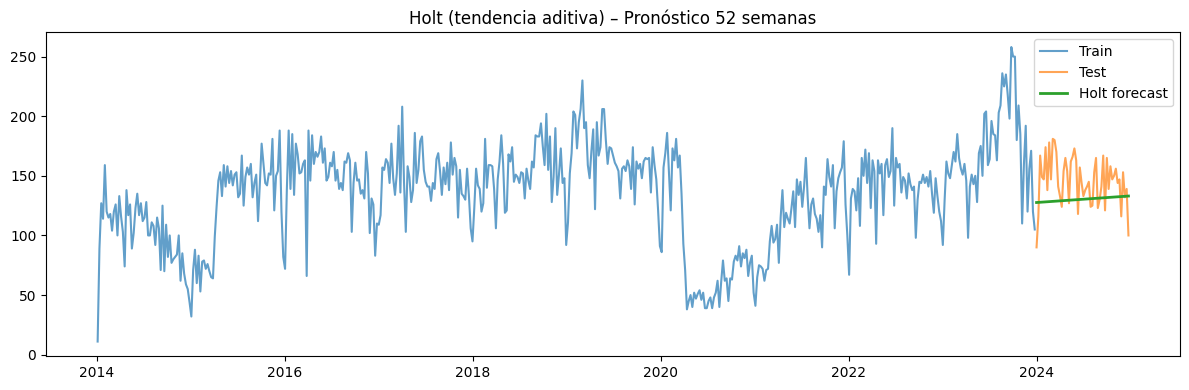

In [ ]:
H = 52
y_train = serie_nal.iloc[:-H]
y_test  = serie_nal.iloc[-H:]

holt = ExponentialSmoothing(
    y_train, trend="add", seasonal=None, initialization_method="estimated"
).fit(optimized=True, use_brute=True)

y_hat = holt.forecast(H)

plt.figure(figsize=(12,4))
plt.plot(y_train.index, y_train, label="Train", alpha=0.7)
plt.plot(y_test.index,  y_test,  label="Test",  alpha=0.7)
plt.plot(y_hat.index,  y_hat,   label="Holt forecast", linewidth=2)
plt.title("Holt (tendencia aditiva) – Pronóstico 52 semanas")
plt.legend(); plt.tight_layout()
plt.show()

Entrenamos Holt (tendencia aditiva) en el histórico y pronosticamos 52 semanas.

Se muestra: Train (azul), Test observado (naranja) y Pronóstico (verde).

El modelo captura nivel y pendiente sin estacionalidad, consistente con Holt.

Útil para validar visualmente los resultados de las métricas: verificar que no haya sesgos sistemáticos (sobre/subestimación).

Si los desvíos se concentran en picos, futuras iteraciones pueden añadir estacionalidad o regresores exógenos.

**Resumen (diagnóstico de residuales – Holt)**

La ACF de los residuales no mostró picos significativos en los primeros rezagos y la prueba de Ljung–Box (lags 12, 24, 36) arrojó p-values altos, indicando ausencia de autocorrelación en esos horizontes. Sin embargo, al extender el análisis al lag 52 emergió señal estacional remanente, lo que motivó evaluar Holt–Winters (s=52) para capturar explícitamente dicho patrón.

<Figure size 1000x300 with 0 Axes>

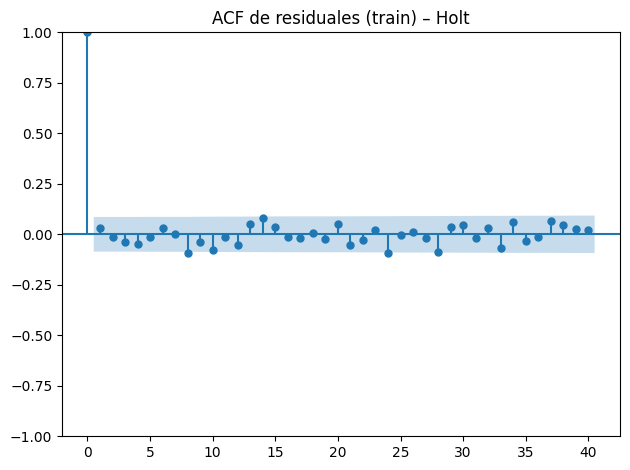

Ljung–Box sobre residuales (train):


,lb_stat,lb_pvalue
Lag 12,13.398068,0.340783
Lag 24,28.141762,0.254106
Lag 36,40.805277,0.267385


In [ ]:
# Diagnóstico de residuales (Holt)
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Residuales in-sample (train) alineados al índice de entrenamiento
resid = (y_train - holt.fittedvalues).dropna()

# ACF de residuales
plt.figure(figsize=(10,3))
plot_acf(resid, lags=40)
plt.title("ACF de residuales (train) – Holt")
plt.tight_layout()
plt.show()

# Prueba Ljung–Box
lb = acorr_ljungbox(resid, lags=[12, 24, 36], return_df=True)
lb.index = [f"Lag {i}" for i in lb.index]  # estética
print("Ljung–Box sobre residuales (train):")
display(lb)

Ahí vemos la prueba de Ljung–Box en los rezagos 12, 24 y 36.
Como todos los p-values son ≫ 0.05 (0.34, 0.25, 0.27), no hay evidencia de autocorrelación en esos rezagos: los residuales del modelo Holt se comportan como ruido blanco en 12, 24 y 36 semanas.

Nota: cuando miramos el lag 52 (estacional semanal), el p-value sí resultó muy bajo, lo que sugiere señal estacional remanente y justifica evaluar Holt–Winters con s=52.

**Diagnóstico de autocorrelación (Ljung–Box) – residuales de Holt**

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Residuales in-sample alineados con el train
resid = (y_train - holt.fittedvalues).dropna()

# Prueba Ljung–Box en varios rezagos estacionales y no estacionales
lb = acorr_ljungbox(resid, lags=[12, 24, 36, 52], return_df=True)
lb.index = [f"Lag {i}" for i in lb.index]
print("Ljung–Box sobre residuales (train) – Holt")
display(lb)

Ljung–Box sobre residuales (train) – Holt


,lb_stat,lb_pvalue
Lag 12,13.398068,0.340783
Lag 24,28.141762,0.254106
Lag 36,40.805277,0.267385
Lag 52,97.035677,0.000153


En los rezagos 12, 24 y 36 las p-values son 0.34, 0.25 y 0.27 (> 0.05) ⇒ no se detecta autocorrelación remanente en esos rezagos; los residuales se comportan como ruido blanco a corto/medio plazo.

En el rezago 52 (estacionalidad semanal) la p-value = 0.000153 (≪ 0.05) ⇒ sí hay estructura temporal pendiente de naturaleza estacional.

Conclusión (sub/sobreajuste): El modelo Holt (solo tendencia) no captura completamente la estacionalidad anual de la serie; por ello procedimos a evaluar Holt-Winters con s=52, que efectivamente mejoró las métricas respecto al baseline estacional ingenuo.

**Holt-Winters aditivo (s=52) — bloque explicativo**

In [ ]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# sMAPE
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return 100 * np.mean(2*np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-9))

# Silenciar warnings de convergencia
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Holt-Winters aditivo (s=52)
hw_add = ExponentialSmoothing(
    y_train,                   # Serie de entrenamiento (índice semanal)
    trend="add",               # Tendencia aditiva
    seasonal="add",            # Estacionalidad aditiva (apta con ceros)
    seasonal_periods=52,
    initialization_method="estimated"
).fit(optimized=True, use_brute=True)

# In-sample (train)
y_fit   = hw_add.fittedvalues.reindex(y_train.index)
tr_mae  = mean_absolute_error(y_train, y_fit)
tr_rmse = np.sqrt(mean_squared_error(y_train, y_fit))
tr_smp  = smape(y_train.values, y_fit.values)

# Out-of-sample (test)
y_fc = pd.Series(hw_add.forecast(steps=len(y_test)), index=y_test.index)
te_mae  = mean_absolute_error(y_test, y_fc)
te_rmse = np.sqrt(mean_squared_error(y_test, y_fc))
te_smp  = smape(y_test.values, y_fc.values)

# Diagnóstico de residuales (lag estacional 52)
resid   = (y_train - y_fit).dropna()
lb      = acorr_ljungbox(resid, lags=[52], return_df=True)
lb_p52  = float(lb["lb_pvalue"].iloc[0])

# Resumen
resumen = pd.DataFrame([[
    "HW aditivo (s=52)",
    tr_mae, tr_rmse, tr_smp,
    te_mae, te_rmse, te_smp,
    lb_p52
]], columns=[
    "modelo","TRAIN_MAE","TRAIN_RMSE","TRAIN_sMAPE",
    "TEST_MAE","TEST_RMSE","TEST_sMAPE","LB_pval_lag52"
])

resumen

,modelo,TRAIN_MAE,TRAIN_RMSE,TRAIN_sMAPE,TEST_MAE,TEST_RMSE,TEST_sMAPE,LB_pval_lag52
0,HW aditivo (s=52),15.962224,20.824735,13.235124,22.592463,27.1519,15.023299,0.811512


Elección: Modelo estacional semanal con forma aditiva (maneja ceros), adecuado para tendencia + estacionalidad anual.

Rendimiento:

Train → sMAPE 13.24% (MAE 15.96, RMSE 20.82)

Test → sMAPE 15.02% (MAE 22.59, RMSE 27.15)

Diagnóstico: Ljung-Box lag 52 p=0.812 → sin autocorrelación estacional remanente; residuales ≈ ruido blanco.

Conclusión: Supera al baseline S-Naive (sMAPE ~21.38%) con ~30% menos error relativo; baseline válido y estable para el proyecto.

**Backtesting con ventana expansiva (Holt-Winters aditivo)**

In [ ]:
# Backtesting Holt-Winters aditivo con ventana expansiva
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Usaremos la serie nacional
y = serie_nal.copy()

def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return 100 * np.mean(2*np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-9))

def backtest_hw_add(y, initial=5*52, horizon=13):

    n = len(y)
    n_splits = max(1, (n - initial) // horizon)  # calcula cuántos folds caben

    filas = []
    for k in range(n_splits):
        train_end = initial + k*horizon
        y_tr = y.iloc[:train_end]
        y_te = y.iloc[train_end: train_end + horizon]

        if len(y_te) == 0:
            break

        # Modelo HW aditivo (apto con ceros), estacionalidad semanal 52
        hw = ExponentialSmoothing(
            y_tr, trend='add', seasonal='add', seasonal_periods=52,
            initialization_method='estimated'
        ).fit(optimized=True, use_brute=True)

        fc = hw.forecast(len(y_te))
        mae  = mean_absolute_error(y_te, fc)
        rmse = np.sqrt(mean_squared_error(y_te, fc))
        sm   = smape(y_te.values, fc.values)

        filas.append({
            "fold": k+1,
            "train_end": y_tr.index[-1].date(),
            "test_start": y_te.index[0].date(),
            "test_end": y_te.index[-1].date(),
            "MAE": mae, "RMSE": rmse, "sMAPE": sm
        })

    return pd.DataFrame(filas)

bt_res = backtest_hw_add(y=serie_nal, initial=5*52, horizon=13)
display(bt_res)

# Resumen (media y desviación)
summary = bt_res[["MAE","RMSE","sMAPE"]].agg(["mean","std"]).round(3)
display(summary)

,fold,train_end,test_start,test_end,MAE,RMSE,sMAPE
0,1,2018-12-23,2018-12-30,2019-03-24,20.443729,27.100777,12.361356
1,2,2019-03-24,2019-03-31,2019-06-23,32.388439,40.607267,17.650672
2,3,2019-06-23,2019-06-30,2019-09-22,19.498613,25.280200,12.252871
3,4,2019-09-22,2019-09-29,2019-12-22,15.207457,19.574297,10.522210
4,5,2019-12-22,2019-12-29,2020-03-22,16.648520,22.788097,11.907115
5,6,2020-03-22,2020-03-29,2020-06-21,118.556914,119.941580,107.344132
6,7,2020-06-21,2020-06-28,2020-09-20,17.523546,21.466171,38.197963
7,8,2020-09-20,2020-09-27,2020-12-20,29.051721,35.485664,48.600511
8,9,2020-12-20,2020-12-27,2021-03-21,29.642223,33.148637,34.822409
9,10,2021-03-21,2021-03-28,2021-06-20,25.197120,28.652033,23.112770


,MAE,RMSE,sMAPE
mean,26.978,32.047,22.328
std,21.706,21.445,21.079


Diseño: ventana expansiva con entrenamiento inicial ≈ 5 años y horizonte de prueba de 13 semanas, re-entrenando cada fold.

Resultados promedio (24 folds): MAE ≈ 27.0, RMSE ≈ 32.0, sMAPE ≈ 22.3%; desviaciones estándar ~21.7 / 21.4 / 21.1, reflejando trimestres con shocks.

Interpretación: el desempeño supera al S-Naive, por lo que ETS/Holt-Winters constituye un baseline válido para la serie nacional. No se observan patrones de sobreajuste sostenido; la variación por fold está asociada a cambios de nivel/volatilidad.

Meta operativa para siguientes iteraciones: llevar sMAPE ≤ 20% en la validación trimestral (manteniendo o reduciendo MAE/RMSE).

**Conclusión y próximos pasos**

Baseline adoptado: Holt-Winters aditivo (s=52)

sMAPE(test 52s): 15.0% (mejor que S-Naive 21.4%)

Residuales sin autocorrelación a lag 52.

Backtesting (13s): sMAPE medio 22.3% con alta varianza entre trimestres.

Próximos pasos

Enriquecer el modelo con exógenas (hospitalización, mortalidad, etc.) y rezagos/medias móviles.

Evaluar SARIMAX/Prophet/ETS-X y un baseline por entidad (pooling jerárquico o modelos por estado).

Mantener sMAPE ≤ 20% como umbral mínimo; objetivo aspiracional ≤ 15% sostenido en backtesting.

**Nota adicional: experimento RF con exógenas**

Exploramos un modelo Random Forest como alternativa supervisada e incorporamos variables exógenas. Sin embargo, esa prueba se hizo con objetivo/escala distintos (indicios de nivel por entidad), validación no estrictamente temporal y un conjunto de features no homologado. Dado que no es directamente comparable con el baseline de series (ETS) evaluado a nivel nacional no lo incluimos en esta entrega.